# How to build your own time series model/dataset?

In this tutorial, we will show how to build a model or dataset for benchmarking from scratch.

## Unconditional Case
### 1. Base Model class
To join `GenTS` model zoo, your model should inherit `BaseModel` class, implementing:
- `ALLOW_CONDITION`: class attribute, indicating the allowed condition types (`predict`, `impute`, `class`, `None`)
- `__init__`: initialization function. The must-have arguments include `seq_len`(int, the length of time series sequence), `seq_dim`(int, the dimension of time series sequence), `condition`(str, the condition type, choose from `ALLOW_CONDITION`)
- `_sample_impl(self, n_sample, condition=None, **kwargs)`: sampling logic, indicating how to sample a time series after training.
- `training_step(self, batch, batch_idx)`: training step logic
- `validation_step(self, batch, batch_idx)`: validation step logic, optional
- `configure_optimizers`: config optimizer(s).

Essentially, `BaseModel` roots from `lightning.LightningModule`, therefore `training_step`, `validation_step`, and `configure_optimizers` are from `LightningModule`. Please check our API documents or [this website](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) for details.

For example, we will show how to customize a VAE model with MLP backbone.

In [1]:
import torch
from gents.model.base import BaseModel
from torchvision.ops import MLP
from torch.nn import functional as F


def kl_loss(z_post_mean, z_post_logvar, z_prior_mean, z_prior_logvar):
    # COMPUTE KL DIV
    z_post_var = torch.exp(z_post_logvar)
    z_prior_var = torch.exp(z_prior_logvar)
    kld_z = 0.5 * (
        z_prior_logvar
        - z_post_logvar
        + ((z_post_var + torch.pow(z_post_mean - z_prior_mean, 2)) / z_prior_var)
        - 1
    )
    return kld_z

class MyVAE(BaseModel):
    # We show unconditional vae as a simple example
    ALLOW_CONDITION = [None]

    def __init__(self, seq_len, seq_dim, latent_dim, condition, **kwargs):
        super().__init__(seq_len, seq_dim, condition, **kwargs)
        self.w_kl = 1e-3 # weight for KL loss
        self.seq_len = seq_len
        self.seq_dim = seq_dim
        self.latent_dim = latent_dim

        # Define encoder and decoder networks
        self.encoder = MLP(seq_dim * seq_len, [256, 256, latent_dim])
        self.decoder = MLP(latent_dim, [256, 256, seq_dim * seq_len])

        # z network
        self.fc_mu = MLP(latent_dim, [latent_dim])
        self.fc_logvar = MLP(latent_dim, [latent_dim])

    def _sample_impl(self, n_sample=1, condition=None, **kwargs):
        z = torch.randn((n_sample, self.latent_dim)).to(self.device)
        all_samples = self.decoder(z).reshape(n_sample, self.seq_len, self.seq_dim)
        return all_samples

    def training_step(self, batch, batch_idx):
        ##################################################
        # See next code block on what we have in a batch #
        ##################################################
        x = batch["seq"].flatten(1)
        
        # encode
        latents = self.encoder(x)
        mu = self.fc_mu(latents)
        logvar = self.fc_logvar(latents)

        # reparameterize
        eps = torch.randn_like(logvar)
        std = torch.exp(0.5 * logvar)
        z = mu + eps * std

        # decode
        x_hat = self.decoder(z).reshape(x.shape)

        # reconstruction loss
        recons_loss = F.mse_loss(x_hat, x)
        
        # KL divergence loss
        mu_prior = torch.zeros_like(z)
        logvar_prior = torch.zeros_like(z)
        kld_loss = kl_loss(mu, logvar, mu_prior, logvar_prior)
        kld_loss = torch.sum(kld_loss) / x.shape[0]
        
        # training loss
        loss = recons_loss + self.w_kl * kld_loss   
        return loss

    def validation_step(self, *args, **kwargs):
        # validation logic can be implemented similar to training step
        # To make this tutorial simple, we just skip the validation step
        return super().validation_step(*args, **kwargs)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

/home/user/workspaces/GenTS/gents/model/vae/timevqvae/_vq.py:182: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
CUDA extension for cauchy multiplication not found. Install by going to extensions/cauchy/ and running `python setup.py install`. This should speed up end-to-end training by 10-50%
Falling back on slow Cauchy kernel. Install at least one of pykeops or the CUDA extension for efficiency.
Falling back on slow Vandermonde kernel. Install pykeops for improved memory efficiency.


### 2. Batch data
In `GenTS`, we also standardize the popular time series datasets into `lightning.DataModule`. For a data batch in a dataloader, we have:
- `seq`: `[batch_size, total_seq_len, seq_dim]`. Target time series window
- `t`: `[batch_size, total_seq_len]`. Time step index at each time step in the window. Default [0,1,2,...]
- `data_mask`: `[batch_size, total_seq_len, seq_dim]`. Time series data mask
- `c`: Optional. `[batch_size, obs_len / seq_len]`. Condition. Empty if unconditional.
- `coeffs`: Optional. `[batch_size, total_seq_len, seq_dim]`. Coefficients of cubic spline/linear interp. of NCDE-related models. Empty if no need to interpolate.
  
We first show a case of unconditional dataset.

In [2]:
from gents.dataset import Spiral2D

dm_uncond = Spiral2D(
    seq_len=32,
    batch_size=64,
    num_samples=3000,
    data_dir="mydata/",
    condition=None,
)

# To illustrate a data batch here, we should call prepare_data and setup first
# You can also directly put datamodule into a Trainer, then Trainer will call these two functions automatically
dm_uncond.prepare_data()
dm_uncond.setup('fit')
batch = next(iter(dm_uncond.train_dataloader()))
print({k: v.shape for k, v in batch.items()})

{'seq': torch.Size([64, 32, 2]), 't': torch.Size([64, 32]), 'data_mask': torch.Size([64, 32, 2])}


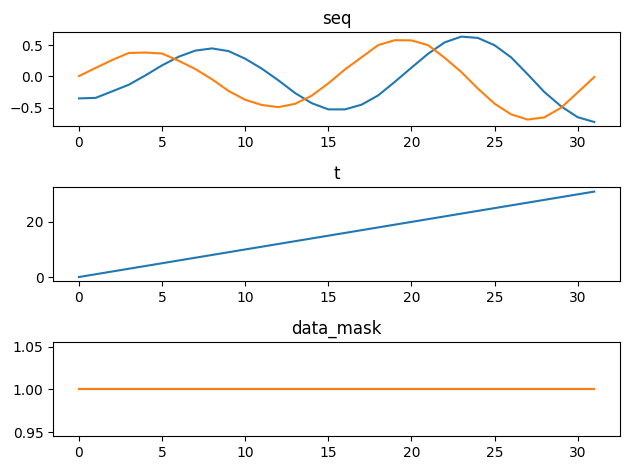

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3)
for i, (k, v) in enumerate(batch.items()):
    axs[i].plot(v[0, :])
    axs[i].set_title(k)
fig.tight_layout()

### 3. setup training
Utilizing `lightning`/`pytorch-lightning`, one can easily set:
- GPU devices
- Training epochs/steps
- Callbacks
- etc..

In [4]:
from lightning import Trainer
model = MyVAE(seq_len=32, seq_dim=2, latent_dim=16, condition=None)
trainer = Trainer(max_steps=500, devices=[0], enable_progress_bar=False)
trainer.fit(model, dm_uncond)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type | Params | Mode 
-------------------------------------------
0 | encoder   | MLP  | 86.5 K | train
1 | decoder   | MLP  | 86.6 K | train
2 | fc_mu     | MLP  | 272    | train
3 | fc_logvar | MLP  | 272    | train
-------------------------------------------
173 K     Trainable params
0         Non-trainable params
173 K     Total params
0.695     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
`Train

### 4. Sampling from the trained model

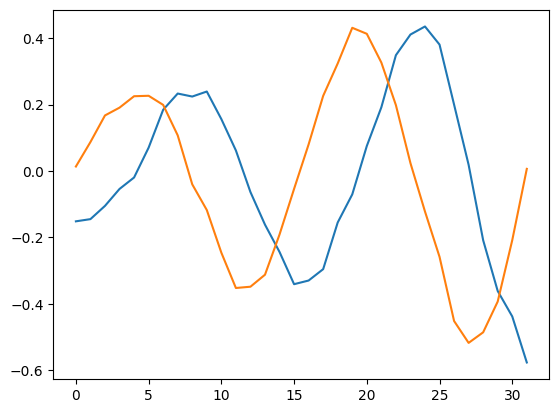

In [5]:
# generate samples with the same number as real data
gen_data = model.sample(n_sample=10)  # [N, 64, 2]
plt.plot(gen_data[0, :])

## Conditional Case
For conditional generation, we have to (1) set conditions in the dataset, and (2) handle the condition input in the model.

Here we show case how to perform forecasting with Conditional VAE

### 1. Conditional Model
Besides the above mentioned arguments, `obs_len` (int, observed length) should also be added as an argument.

In [ ]:
class MyCondVAE(BaseModel):
    # Forecasting model
    ALLOW_CONDITION = ["predict"]

    def __init__(self, seq_len, seq_dim, latent_dim, condition, **kwargs):
        super().__init__(seq_len, seq_dim, condition, **kwargs)
        self.w_kl = 1e-3  # weight for KL loss
        self.seq_len = seq_len
        self.seq_dim = seq_dim
        self.obs_len = kwargs.get("obs_len")
        self.latent_dim = latent_dim

        # Define encoder, decoder and condition embedding networks
        self.encoder = MLP(seq_dim * seq_len, [256, 256, latent_dim])
        self.decoder = MLP(latent_dim, [256, 256, seq_dim * seq_len])
        self.cond_embed = MLP(seq_dim * self.obs_len, [256, 256, latent_dim])

        # z network (concat the condition embedding and sequence embedding)
        self.fc_mu = MLP(latent_dim, [latent_dim])
        self.fc_logvar = MLP(latent_dim, [latent_dim])

    def _sample_impl(self, n_sample=1, condition=None, **kwargs):
        # For conditional model, n_sample is the number of samples per condition
        all_samples = []
        for i in range(n_sample):
            z = torch.randn((condition.shape[0], self.latent_dim)).to(self.device)
            cond_lats = self.cond_embed(condition.flatten(1))
            z = z + cond_lats
            x_hat = self.decoder(z).reshape(
                condition.shape[0], self.seq_len, self.seq_dim
            )
            all_samples.append(x_hat)
        all_samples = torch.stack(all_samples, dim=-1)
        return all_samples
        

    def training_step(self, batch, batch_idx):
        # batch['seq'] is the full sequence (obs + pred)
        x = batch["seq"][:, -self.seq_len :].flatten(1)
        c = batch.get("c")

        # encode 
        latents = self.encoder(x)
        cond_latent = self.cond_embed(c.flatten(1))
        latents = latents + cond_latent

        # output the parameters of q(z|x,c)
        mu = self.fc_mu(latents)
        logvar = self.fc_logvar(latents)

        # reparameterize
        eps = torch.randn_like(logvar)
        std = torch.exp(0.5 * logvar)
        z = mu + eps * std

        # decode
        z = z + cond_latent
        x_hat = self.decoder(z).reshape(x.shape)

        # reconstruction loss
        recons_loss = F.mse_loss(x_hat, x)

        # KL divergence loss
        mu_prior = torch.zeros_like(z)
        logvar_prior = torch.zeros_like(z)
        kld_loss = kl_loss(mu, logvar, mu_prior, logvar_prior)
        kld_loss = torch.sum(kld_loss) / x.shape[0]

        # training loss
        loss = recons_loss + self.w_kl * kld_loss
        return loss

    def validation_step(self, *args, **kwargs):
        # validation logic can be implemented similar to training step
        # To make this tutorial simple, we just skip the validation step
        return super().validation_step(*args, **kwargs)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

Visualize the forecasting data batch

{'seq': torch.Size([64, 64, 2]), 't': torch.Size([64, 64]), 'data_mask': torch.Size([64, 64, 2]), 'c': torch.Size([64, 32, 2])}


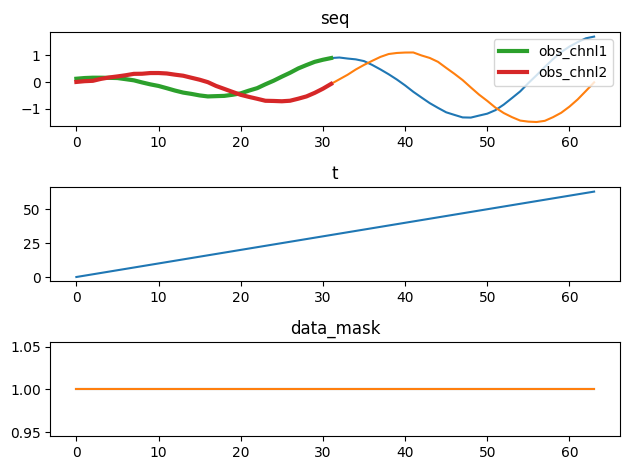

In [7]:
dm_cond = Spiral2D(
    seq_len=32,
    obs_len=32,
    batch_size=64,
    num_samples=3000,
    data_dir="mydata_cond/",
    condition='predict',
)

# To illustrate a data batch here, we should call prepare_data and setup first
# You can also directly put datamodule into a Trainer, then Trainer will call these two functions automatically
dm_cond.prepare_data()
dm_cond.setup('fit')
batch = next(iter(dm_cond.train_dataloader()))
print({k: v.shape for k, v in batch.items()})

fig, axs = plt.subplots(3)
for i, (k, v) in enumerate(batch.items()):
    if k == 'c':
        axs[0].plot(v[0, :], label=['obs_chnl1', 'obs_chnl2'], lw=3)
        axs[0].legend()
    else:
        axs[i].plot(v[0, :])
        axs[i].set_title(k)
fig.tight_layout()

In [8]:
model = MyCondVAE(seq_len=32, obs_len=32, seq_dim=2, latent_dim=16, condition='predict')
trainer = Trainer(max_steps=500, devices=[0], enable_progress_bar=False)
trainer.fit(model, dm_cond)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type | Params | Mode 
--------------------------------------------
0 | encoder    | MLP  | 86.5 K | train
1 | decoder    | MLP  | 86.6 K | train
2 | cond_embed | MLP  | 86.5 K | train
3 | fc_mu      | MLP  | 272    | train
4 | fc_logvar  | MLP  | 272    | train
--------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.041     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


`Trainer.fit` stopped: `max_steps=500` reached.


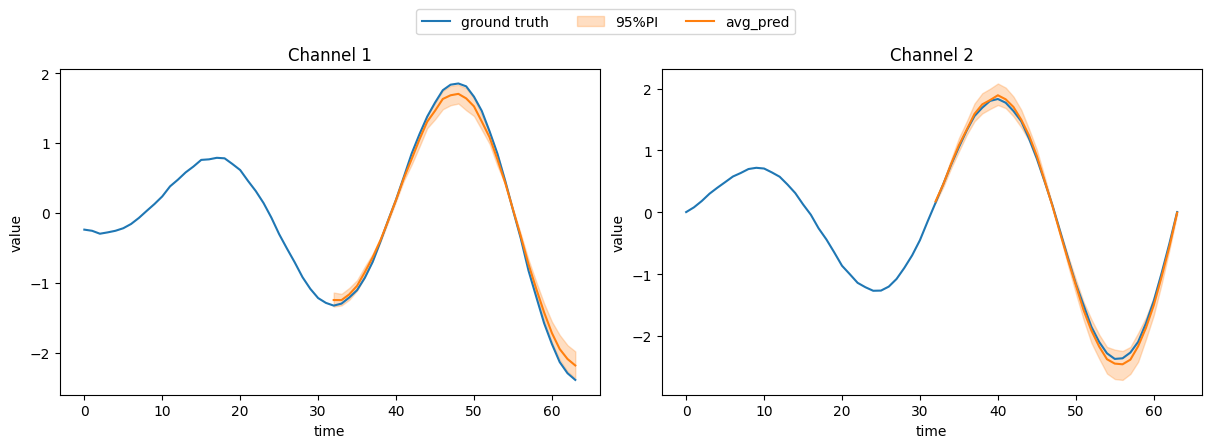

In [ ]:
from gents.evaluation import predict_visual

dm_cond.setup("test")
real_data = torch.cat([batch["seq"] for batch in dm_cond.test_dataloader()])
cond_data = torch.cat([batch["c"] for batch in dm_cond.test_dataloader()])

gen_data = model.sample(
    n_sample=10,
    condition=cond_data,
)

predict_visual(
    real_data=real_data,
    gen_data=gen_data,
    data_mask=torch.ones_like(real_data).bool(),
    # uncomment the following line to save the plot
    # save_root='./predict.png'
)